In [1]:
!pip install tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix

In [4]:
model = tf.keras.models.Sequential([
# YOUR CODE HERE
    # First Convolutional Layer
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second Convolutional Layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third Convolutional Layer
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation = 'relu'),
    # Only one output neuron as this is a binary classifier
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [5]:
TRAINING_DIR = "data training"
train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )
 
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=15,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
VALIDATION_DIR = "data validation"
validation_datagen = ImageDataGenerator(rescale=1.0/255)
 
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=15,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 3080 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [6]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


In [7]:
history = model.fit(train_generator,
                    epochs=5, 
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Epoch 1/5
206/206 [==============================] - 114s 549ms/step - loss: 0.3909 - acc: 0.8377 - val_loss: 0.1511 - val_acc: 0.9540
Epoch 2/5
206/206 [==============================] - 105s 509ms/step - loss: 0.2516 - acc: 0.9026 - val_loss: 0.1716 - val_acc: 0.9527
Epoch 3/5
206/206 [==============================] - 120s 582ms/step - loss: 0.2229 - acc: 0.9175 - val_loss: 0.1525 - val_acc: 0.9463
Epoch 4/5
206/206 [==============================] - 294s 1s/step - loss: 0.2171 - acc: 0.9185 - val_loss: 0.1529 - val_acc: 0.9514
Epoch 5/5
206/206 [==============================] - 156s 758ms/step - loss: 0.1947 - acc: 0.9282 - val_loss: 0.1020 - val_acc: 0.9629


Text(0.5, 1.0, 'Training and validation loss')

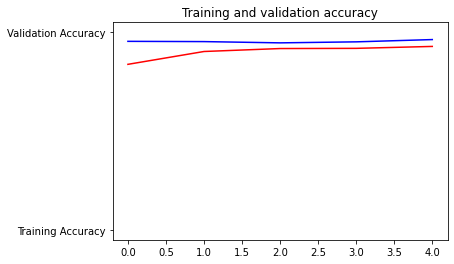

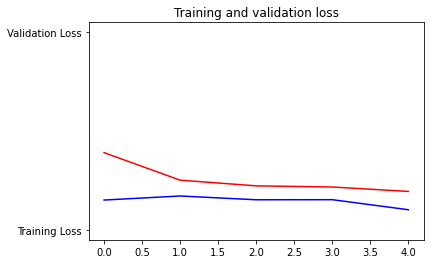

In [10]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("model2-001.model")
 
results={0:'Tanpa masker',1:'Menggunakan masker'}
GR_dict={0:(0,0,255),1:(0,255,0)}
 
rect_size = 4
cap = cv2.VideoCapture(0) 
 
 
haarcascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
 
while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 
 
     
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
         
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
 

        label=np.argmax(result,axis=1)[0]
       
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
 
    cv2.imshow('Deteksi Masker real-time openCV',   im)
    key = cv2.waitKey(10)
     
    if key == 27: 
        break
 
cap.release()
 
cv2.destroyAllWindows()